# Load Essential Libraries

In [2]:
import os
import re
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn import tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load Training Data

In [8]:
def read_by_lines(list_file, dir_path, list_filled):
    
    for labels in list_file:
    
        with open(dir_path + labels, "r") as file:

            for readline in file: 
                line_strip = readline.strip()
                
                if line_strip == "1": 
                    list_filled.append(1) # unfair
                elif line_strip == "-1":
                    list_filled.append(0) # fair
                else:
                    list_filled.append(line_strip)

    return list_filled

In [11]:
dir_label = "data/Labels/"
dir_sentences = "data/Sentences/"

list_file_labels = os.listdir(dir_label)
list_file_sentences = os.listdir(dir_sentences)

list_label = []
list_sentences = []

list_label = read_by_lines(list_file_labels, dir_label, list_label)
list_sentences = read_by_lines(list_file_sentences, dir_sentences, list_sentences)

In [12]:
print("NUMBER OF LABELS:", len(list_label))
print("NUMBER OF UNFAIR CASES:", list_label.count(1))
print("NUMBER OF FAIR CASES:", list_label.count(0))

NUMBER OF LABELS: 9414
NUMBER OF UNFAIR CASES: 1032
NUMBER OF FAIR CASES: 8382


In [13]:
print("NUMBER OF SENTENCES:", len(list_sentences))

NUMBER OF SENTENCES: 9414


## 1.1 Convert Pandas to Dataframe

In [16]:
data = pd.DataFrame({'label':list_label, 'sentence':list_sentences})

In [17]:
data

,label,sentence
0,0,* accepting the terms of service
1,0,"the purpose of this website , 9gag ."
2,0,"com -lrb- the `` site '' -rrb- , owned and ope..."
3,0,please read these terms of service -lrb- `` ag...
4,1,"by using or accessing the services , you agree..."
...,...,...
9409,0,you agree that given the unique and irreplacea...
9410,0,"therefore , for disputes that are not required..."
9411,0,you agree to limit your claims to claims for m...
9412,0,"and , you agree not to seek injunctive or equi..."


In [30]:
from sklearn.model_selection import train_test_split

X = data.sentence.values
y = data.label.values

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - train_ratio, random_state=42, stratify=y)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42, stratify=y_test) 

In [31]:
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape: ", X_test.shape)

Train shape: (7060,)
Validation shape: (1412,)
Test shape:  (942,)


In [28]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


# 2. Fine Tuning BERT

In [48]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))

stemer = PorterStemmer()

special_chars = re.compile('[^⁰9a-z#+_]')
add_space = re.compile('[/(){}\[\]\\@;]')
                             
def clean_text(text):
    text = text.lower()
    text = add_space.sub(' ',text)
    text = special_chars.sub(' ',text)
    
    return re.sub(' +', ' ', text)

In [49]:
# Print sentence 0
print('Original: ', X[2])
print('Processed: ', clean_text(X[2]))

Original:  com -lrb- the `` site '' -rrb- , owned and operated by 9gag , inc , is to provide web publishing services .
Processed:  com lrb the site rrb owned and operated by 9gag inc is to provide web publishing services 


## 2.1 BERT Tokenizer

In [50]:
from transformers import BertTokenizer

In [51]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [55]:
all_sentences = data.sentence.values

# Encode our concatenated data
encoded_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_sentences]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_sentences])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


Max length:  567


In [63]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
test_inputs, test_masks = preprocessing_for_bert(X_test)

C:\Users\merve\Anaconda3\envs\myenv\lib\site-packages\transformers\tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  * accepting the terms of service
Token IDs:  [101, 1008, 10564, 1996, 3408, 1997, 2326, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


### 2.2. Create PyTorch DataLoader

In [65]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## 3. Train the Model

### 3.1. Create BertClassifier

In [58]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

### 3.2. Optimizer & Learning Rate Scheduler

In [59]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [60]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [61]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\merve\Anaconda3\envs\myenv\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will 

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.413713   |     -      |     -     |  228.89  
   1    |   40    |   0.274647   |     -      |     -     |  241.30  
   1    |   60    |   0.238884   |     -      |     -     |  262.27  
   1    |   80    |   0.204656   |     -      |     -     |  241.84  
   1    |   100   |   0.211175   |     -      |     -     |  267.75  
   1    |   120   |   0.222579   |     -      |     -     |  260.71  
   1    |   140   |   0.167953   |     -      |     -     |  289.56  
   1    |   160   |   0.193540   |     -      |     -     |  274.66  
   1    |   180   |   0.185484   |     -      |     -     |  274.82  
   1    |   200   |   0.167488   |     -      |     -     |  302.98  
   1    |   220   |   0.124535   |     -      |     -     |  281.01  
----------------------------------------------------------------------

### 3.3. Evaluation on Test Set

In [62]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [67]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9589
Accuracy: 94.06%


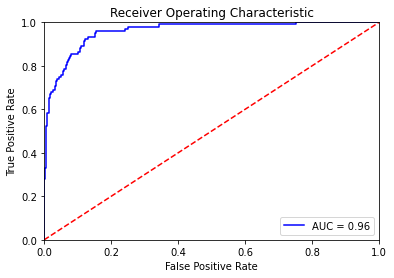

In [68]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)